In [1]:
import math
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

相関正規乱数の生成...資産価格とボラティリティのように、正規乱数において相関を考慮することは現実のケースでも往々にしてある。独立した2つの標準正規乱数$x_1$,$x_2$から相関を持つ標準正規乱数$\varepsilon_1$,$\varepsilon_2$の生成は以下で求められる。
$$\varepsilon_1=x_1$$
$$\varepsilon_2=\rho x_1+\sqrt{1-\rho^2}x_2$$
$$\rho=\text{corr}(x_1,x_2)$$
このように、2つの相関正規乱数の生成は容易に行える。3つ以上の場合は複雑で、コレスキー分解を用いた多変数の相関正規乱数の生成を行う。


コレスキー分解...$C$を対称な正定値行列とすると、$C$を下三角行列$L$とその転置$L^T$に分解できる（分解の仕方は一意である）
$$C=LL^T$$
相関係数行列$C$は対称で正定値なのでコレスキー分解が可能である。これにより、無相関の標準正規乱数ベクトルを$X=(x_1,\dots,x_n)^T$に対して、相関をもつ標準正規乱数ベクトル$\varepsilon=(\varepsilon_1,\dots,\varepsilon_n)^T$は以下のように下三角行列$L$との積で求められる。
$$\varepsilon=LX$$

実際、
$$\varepsilon\varepsilon^T=LXX^TL^T$$
$$E[\varepsilon\varepsilon^T]=LE[XX^T]L^T$$
$$E[\varepsilon\varepsilon^T]=E[(\varepsilon-0)(\varepsilon-0)^T]=C$$
$$LE[XX^T]L^T=LE[1]L^T=LL^T$$
となり、コレスキー分解から相関をもつ標準正規乱数が求まる。

（例）以下の行列 $C$をコレスキー分解する。
$$C=\begin{pmatrix}4&&1&&2\\1&&5&&3\\2&&3&&6\end{pmatrix}$$
$$L=\begin{pmatrix}l_{11}&&0&&0\\l_{21}&&l_{22}&&0\\l_{31}&&l_{32}&&l_{33}\end{pmatrix}$$
とおいて、以下の連立方程式を解けばよい。（計算の順番が重要である。）
$$\begin{pmatrix}4&&1&&2\\1&&5&&3\\2&&3&&6\end{pmatrix}
=\begin{pmatrix}l_{11}&&0&&0\\l_{21}&&l_{22}&&0\\l_{31}&&l_{32}&&l_{33}\end{pmatrix}
\begin{pmatrix}l_{11}&&l_{21}&&l_{31}\\0&&l_{22}&&l_{32}\\0&&0&&l_{33}\end{pmatrix}
=\begin{pmatrix}l_{11}^2&&l_{11}l_{21}&&l_{11}l_{31}\\l_{11}l_{21}&&l_{11}^2+l_{22}^2&&l_{21}l_{31}+l_{22}l_{32}\\l_{11}l_{31}&&l_{21}l_{31}+l_{22}l_{32}&&l_{11}^2+l_{22}^2+l_{33}^2\end{pmatrix}$$


Step1.$\ \ \ l_{11}=\sqrt{4}=2$

Step2.$\ \ \ l_{21}=1/l_{11}=1/2=0.5$

Step3.$\ \ \ l_{31}=2/l_{11}=2/2=1$

Step4.$\ \ \ l_{22}=\sqrt{5-l_{21}^2}=\sqrt{5-0.5^2}=2.179$

Step5.$\ \ \ l_{32}=(3-l_{31}l_{21})/l_{22}=(3-1\cdot 0.5)/2.179=1.147$

Step6.$\ \ \ l_{33}=\sqrt{6-l_{31}^2-l_{32}^2}=\sqrt{6-1^2-1.147^2}=1.919$

コレスキー分解で、$\varepsilon_i\ \ (i=1,\dots,n)$が$\varepsilon_j\ \ (j=1,\dots,i-1)$に対して正しい共分散をもつためには、以下の制約条件が必要である。
$$\varepsilon_i=\displaystyle{\sum_{k=1}^i}l_{ik}x_k$$
$$\displaystyle{\sum_{k=1}^i}l_{ik}^2=1$$
$$\displaystyle{\sum_{k=1}^j}l_{ik}l_{jk}=\rho_{i,j}$$

一般化すると、$j<i$に対し
$$l_{ii}=\sqrt{\rho_{i,i}-\sum_{k=1}^{i-1}l_{ik}^2}$$
$$l_{ji}=\cfrac{1}{l_{ii}}\left(\rho_{j,i}-\sum_{k=1}^{i-1}l_{jk}l_{ik}\right)$$

In [25]:
# コレスキー分解
def Cholesky_decomp(C):
    m = C.shape[0]
    n = C.shape[1]

    # 初期化
    L = np.zeros((m, n))

    for i in range(m):
        for j in range(n):
            Temp = C[i, j]
            for k in range(i):
                Temp = Temp - L[i, k] * L[j, k]
            if j == i:
                L[i, i] = np.sqrt(Temp)
            else:
                L[j, i] = Temp / L[i, i]
    return L


In [28]:
C = [[4,1,2],
     [1,5,3],
     [2,3,6]]
C = np.array(C)

L = Cholesky_decomp(C)
L

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


array([[2.        ,        nan,        nan],
       [0.5       , 2.17944947,        nan],
       [1.        , 1.14707867, 1.91942974]])

In [30]:
# コレスキー分解はnumpyでもできる
L = np.linalg.cholesky(C)
print(L)

[[2.         0.         0.        ]
 [0.5        2.17944947 0.        ]
 [1.         1.14707867 1.91942974]]


In [31]:
# 相関正規乱数の生成
def Normal_corr(C, X):
    m = C.shape[0]
    n = C.shape[1]
    # コレスキー分解
    L = np.linalg.cholesky(C)
    # 相関乱数ベクトルの初期化
    eps_corr = np.zeros_like(X)

    for i in range(m):
        Temp = 0
        for j in range(n):
            Temp = Temp + L[i, j]*X[j]  # Xは無相関乱数ベクトル
        eps_corr[i] = Temp

    return eps_corr

[[1.92780825]
 [2.13464093]
 [0.98855616]]


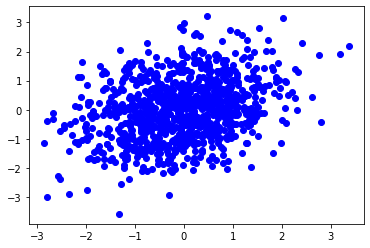

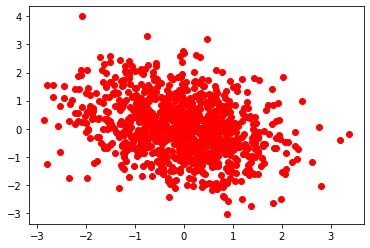

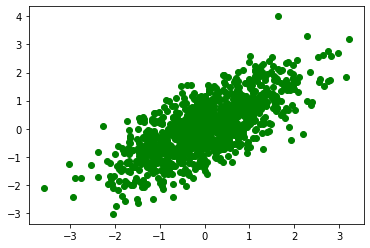

In [40]:
# 相関正規乱数のサンプルと散布図
# 適当な相関係数行列
C = [[1, 0.350, -0.300],
     [0.350, 1, 0.700],
     [-0.300, 0.700, 1]]
C = np.array(C)
m = C.shape[0]

# 無相関正規乱数ベクトル
X = []
for i in range(m):
    eps = np.random.normal(0,1,1)
    X.append(eps)

# 相関正規乱数ベクトル
eps_corr = Normal_corr(C,X)
print(eps_corr)

# 散布図用
x0_vec = []
x1_vec = []
x2_vec = []
for i in range(1000):
    X = []
    for i in range(m):
        eps = np.random.normal(0,1,1)
        X.append(eps)
    eps_corr = Normal_corr(C,X)
    x0_vec.append(eps_corr[0])
    x1_vec.append(eps_corr[1])
    x2_vec.append(eps_corr[2])

# 元々の相関0.350の場合の相関正規乱数
plt.scatter(x0_vec, x1_vec, color='Blue')
plt.show()

# 元々の相関-0.300の場合の相関正規乱数
plt.scatter(x0_vec, x2_vec, color='Red')
plt.show()

# 元々の相関0.700の場合の相関正規乱数
plt.scatter(x1_vec, x2_vec, color='Green')
plt.show()